# Semantic Segmentation


1.Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>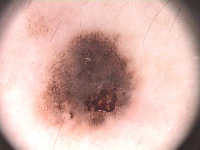</td><td>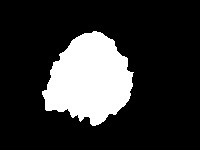</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем сегментировать их.

###Ремарка

Да, наверное, можно было не переписывать всю модель заново каждый раз, когда меня виды апсемплинга, а просто изменять некоторые слои, но так нагляднее и с этими фишками лучше разобраться спокойно в свободное время.
###

###Конец ремарки

In [ ]:
! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

--2020-06-07 19:17:51--  https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/k88qukc20ljnbuo/PH2Dataset.rar [following]
--2020-06-07 19:17:51--  https://www.dropbox.com/s/raw/k88qukc20ljnbuo/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd0ca5e8ef5259b36a3e490999a.dl.dropboxusercontent.com/cd/0/inline/A5PqDq2GlGpCRlK-ibI6_SyFy60l5tnxLzB_SexFJkDtNbu04WWci_NQ492Wj1uWDxibfxF1-9-ieULr-lt_LEEFwI5_9Wgyrk-ULuBzR0soEQ/file# [following]
--2020-06-07 19:17:52--  https://ucd0ca5e8ef5259b36a3e490999a.dl.dropboxusercontent.com/cd/0/inline/A5PqDq2GlGpCRlK-ibI6_SyFy60l5tnxLzB_SexFJkDtNbu04WWci_NQ492Wj1uWDxibfxF1-9-ieULr-lt_LEEFwI5_9Wgyrk-ULuBzR0soEQ/file
Resolving 

In [ ]:
# Если не скачает с dropbox'а 
# from google.colab import drive
# drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# !cp /content/drive/My\ Drive/PH2Dataset.rar /content/
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Для загрузки датасета я предлагаю использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) можно использовать для изменения размера изображений. 
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
print(X.shape, '\n', Y.shape) 

(200, 256, 256, 3) 
 (200, 256, 256)


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

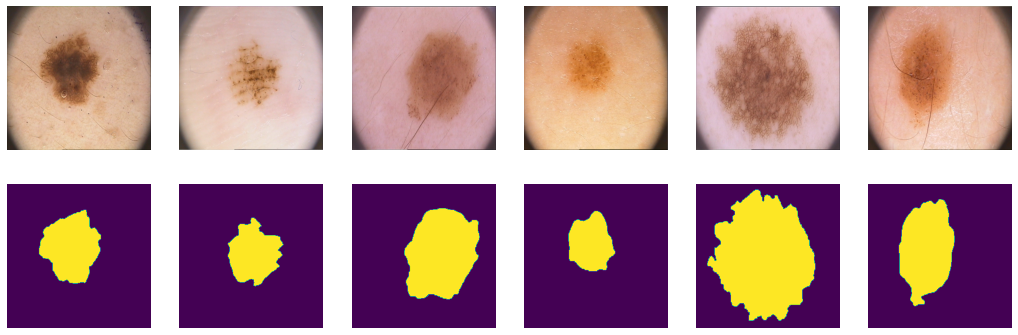

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 10
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

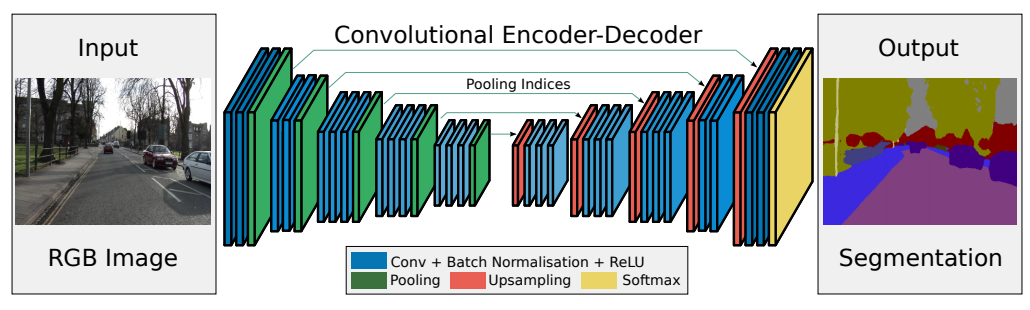

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [ ]:
import random
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim 
from torchsummary import summary
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,6)


SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.enabled = True

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3,32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            )
        self.pool0 = nn.MaxPool2d(2,2)

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        self.pool1 =  nn.MaxPool2d(2,2)

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        self.pool2 = nn.MaxPool2d(2,2)

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )
        self.pool3 = nn.MaxPool2d(2,2)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        # decoder (upsampling)
        
        self.upsample0 = nn.Upsample(32)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )

        self.upsample1 = nn.Upsample(64)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )

        # 64 -> 128
        self.upsample2 = nn.Upsample(128)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
            )
        
        self.upsample3 =  nn.Upsample(256)
        self.dec_conv3 = nn.Conv2d(32, 1, kernel_size=1)
        
    def forward(self, x):

        # encoder
        e0 = self.enc_conv0(x)                

        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b =  self.bottleneck_conv(self.pool3(e3))

        # decoder
        d0 = self.upsample0(b)
        d0 = self.dec_conv0(d0)

        d1 = self.upsample1(d0)
        d1 = self.dec_conv1(d1)


        d2 = self.upsample2(d1)
        d2 = self.dec_conv2(d2)

        d3 = self.upsample3(d2) 
        preds = self.dec_conv3(d3) # no activation

        return preds

In [ ]:
mod = SegNet().to(device)
summary(mod, (3, 256, 256))

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


To clarify this we can see on the segmentation:
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


And the intersection will be the following:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## функция лосса [1 балл]

Теперь не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) в Тарая функция эквивалентна и не так подвержена численной неустойчивости.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_pred, y_real):
    y_pred = torch.sigmoid(y_pred)
    loss_ = (torch.max(y_pred, torch.zeros_like(y_pred)) - y_real * y_pred + torch.log(1. + torch.exp(- torch.abs(y_pred)))).mean()
    return loss_

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr'] 

def train(model, opt, loss_fn, epochs, data_tr, data_val):

    scheduler = torch.optim.lr_scheduler.StepLR(opt, 7, gamma=0.5)
    X_val, Y_val = next(iter(data_val))
    X_val = X_val.to(device)
    Y_val = Y_val.to(device)

    history = []

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        print('lr - ', get_lr(opt))

        avg_loss = 0
        val_loss = 0
        
        model.train()
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss =  loss_fn(Y_pred, Y_batch)
            loss.backward()
            opt.step() # update weights
            

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        
        train_acc_plot = score_model(model, iou_pytorch, data_tr) # add train_acc for plot
        toc = time()
        print('loss: %f' % avg_loss)

        scheduler.step()

        # show intermediate results
        model.eval()
        with torch.no_grad():
            # calc. val loss and acc
            Y_batch_val = model(X_val)
            val_loss =  loss_fn(Y_batch_val, Y_val)
            val_loss += val_loss / len(data_val)
            # for plots
            val_acc_plot = score_model(model, iou_pytorch, data_val)

        X_batch_hat = X_batch.detach().to('cpu')
        Y_train_hat = Y_batch.detach().to('cpu')
        Y_hat = Y_pred.detach().to('cpu') > 0  # detach and put into cpu

        history.append((avg_loss.item(), train_acc_plot, val_loss.item(), val_acc_plot))

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_batch_hat[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(Y_train_hat[k, 0], cmap='gray')
            plt.title('Expected mask')
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            plt.imshow(Y_hat[k, 0], cmap='gray')            
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

    return history

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))
        scores += metric(Y_pred > 0, Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение

In [ ]:
model = SegNet().to(device)

In [ ]:
torch.cuda.empty_cache()

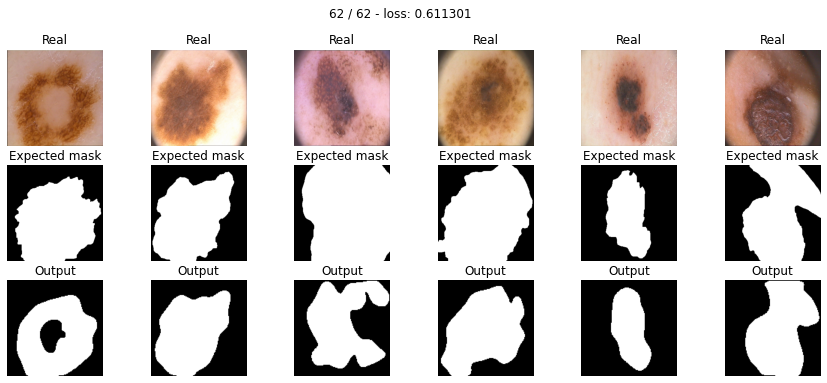

In [ ]:
max_epochs = 62
optim = torch.optim.Adam(model.parameters(), lr=1e-03)
history_Seg_BCE = train(model, optim, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
# torch.save(model.state_dict, '/content/SegNetBCE.pth')
score_model(model, iou_pytorch, data_val)

0.7700000286102295

-----------------------------------------------------------------------------------------

## Дополнительные функции лосса [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

//  Не забудьте подумать о численной нестабильности.


In [ ]:
def dice_loss(y_pred, y_real, smooth=1):
    y_pred = torch.sigmoid(y_pred)
    num = 2. * torch.sum(y_pred * y_real)
    den = torch.sum(y_pred + y_real)
    res = (1. - (num + smooth) / (den + smooth)).mean()
    return res

Проводим тестирование:

In [ ]:
model_dice = SegNet().to(device)

In [ ]:
torch.cuda.empty_cache()

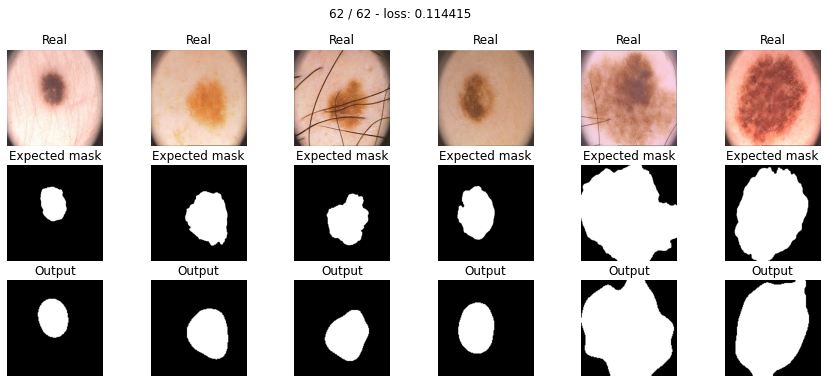

In [ ]:
max_epochs = 62
optimaizer = torch.optim.Adam(model_dice.parameters(), lr=1e-03)
history_Seg_Dice = train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [ ]:
# torch.save(model_dice.state_dict, '/content/SegNetDice_coeff.pth')
score_model(model_dice, iou_pytorch, data_val)

0.7680000185966491

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_pred, y_real, eps=1e-8, alpha=-1., gamma=2):
    y_pred = torch.sigmoid(y_pred)
    pt = y_real * y_pred + (1 - y_real) * (1 - y_pred)
    your_loss = alpha * (1 - pt)**gamma * torch.log(pt + eps) 
    return your_loss.mean()

In [ ]:
model_focal = SegNet().to(device)

In [ ]:
torch.cuda.empty_cache()

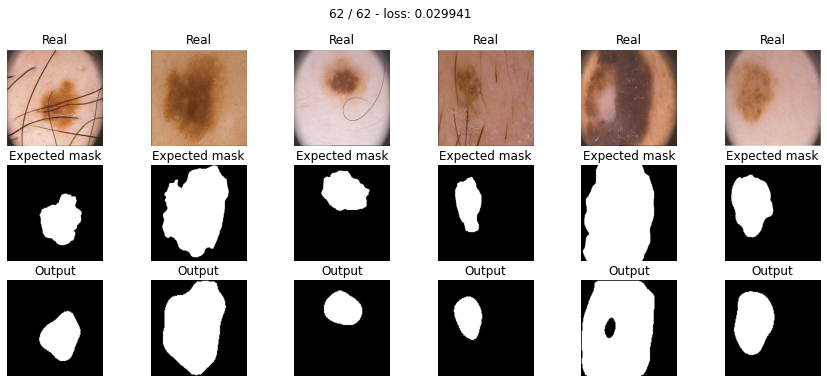

In [ ]:
max_epochs = 62
optimaizer = torch.optim.Adam(model_focal.parameters(), lr=1e-03)
history_Seg_focal = train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

In [ ]:
# torch.save(model_focal.state_dict, '/content/SegNetfocal.pth')
score_model(model_focal, iou_pytorch, data_val)

0.7580000400543213

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаю написать вам 1 функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Tversky loss
5) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

<div style="border-left: solid 6px #d6d6d6; padding: 10px; background-color: #eaeaea">
<b><i>Exercise:</i></b> Add the total variation term to the loss.</div>

In [ ]:
def tversky_loss(y_pred, y_true, beta=0.7, smooth=1e-08):
    y_pred = torch.sigmoid(y_pred)
    num = torch.sum(y_true * y_pred, dim=(2, 3))
    den = torch.sum(y_true * y_pred + beta * (1 - y_true) * y_pred + (1 - beta) * y_true * (1 - y_pred), dim=(2, 3))

    return (1. - (num + smooth) / (den + smooth)).mean()

In [ ]:
model_tversky = SegNet().to(device)

In [ ]:
torch.cuda.empty_cache()

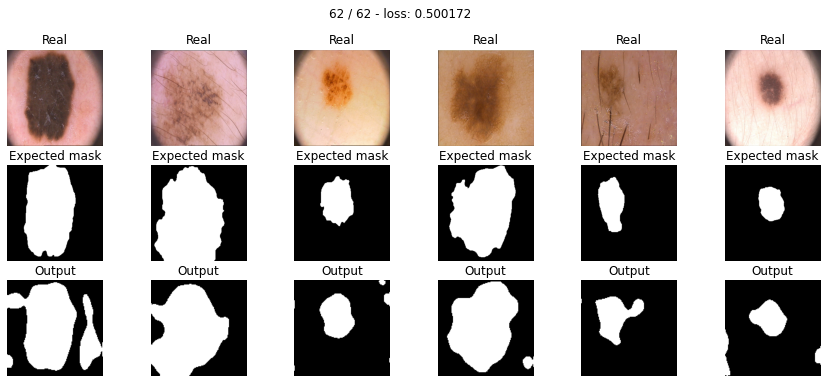

In [ ]:
max_epochs = 62
optimaizer = torch.optim.Adam(model_tversky.parameters(), lr=1e-03)
history_Seg_tversky = train(model_tversky, optimaizer, tversky_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_tversky, iou_pytorch, data_val)

0.5580000162124634

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Учитывая медицинское изображение, он выводит изображение в оттенках серого, представляющее вероятность того, что каждый пиксель является интересующей областью.

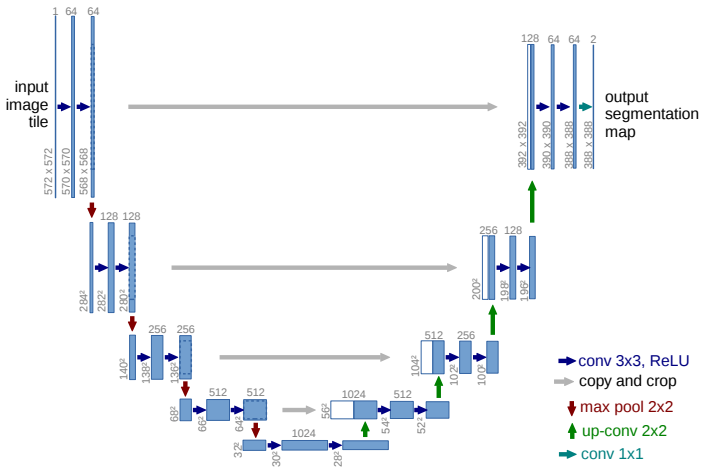

У нас в архитектуре все так же существует енкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются skip-conenctions. Элементы соединяющие части декодера и енкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
'''

Сократить код стоило бы так:

class EncConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(EncConv, self).__init__()
        
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(out_ch)

        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(out_ch)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.conv1_bn(x)

        x = F.relu(self.conv2(x))
        x = self.conv2_bn(x)
        return x
'''

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        #Downsampling
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
            )
        self.pool0 = nn.MaxPool2d(2)

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        self.pool1 =  nn.MaxPool2d(2)

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        self.pool2 = nn.MaxPool2d(2)

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )
        self.pool3 = nn.MaxPool2d(2)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(32)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )

        self.upsample1 = nn.Upsample(64)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(384, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        
        # 64 -> 128
        self.upsample2 = nn.Upsample(128)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(192, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        
        self.upsample3 =  nn.Upsample(256)
        self.dec_conv3_ = nn.Sequential(
            nn.Conv2d(96, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
            )
        
        self.dec_conv3 = nn.Conv2d(32, 1, kernel_size=1)


    def forward(self, x):

        e0 = self.enc_conv0(x) # 32

        e1 = self.enc_conv1(self.pool0(e0)) # 64
        e2 = self.enc_conv2(self.pool1(e1)) # 128
        e3 = self.enc_conv3(self.pool2(e2)) # 256

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3)) # 256

        # decoder
        d0 = self.upsample0(b)
        d0 = torch.cat([d0, e3], dim=1) # 512
        d0 = self.dec_conv0(d0) # 256

        d1 = self.upsample1(d0) 
        d1 = torch.cat([d1, e2], dim=1) # 384
        d1 = self.dec_conv1(d1) # 128

        d2 = self.upsample2(d1)
        d2 = torch.cat([d2, e1], dim=1) # 192
        d2 = self.dec_conv2(d2) # 64

        d3 = self.upsample3(d2)
        d3 = torch.cat([d3, e0], dim=1) # 96
        d3 = self.dec_conv3_(d3) # 96 -> 32

        preds = self.dec_conv3(d3) # 32 -> 1

        return preds

In [ ]:
mod = UNet().to(device)
summary(mod, (3, 256, 256))

In [ ]:
unet_model = UNet().to(device)

In [ ]:
torch.cuda.empty_cache()

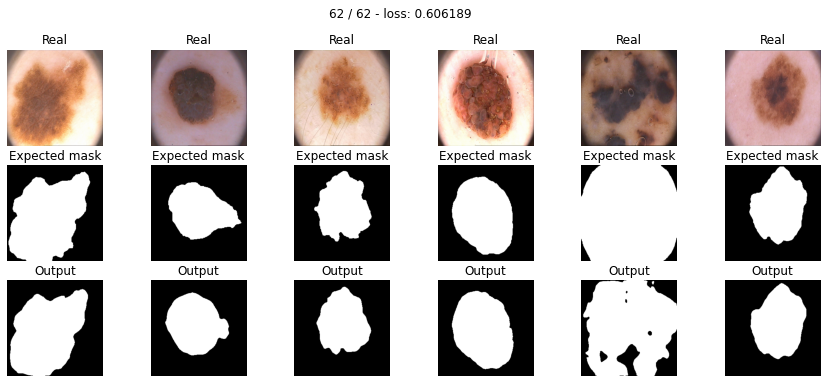

In [ ]:
history_Unet_BCE = train(unet_model, torch.optim.Adam(unet_model.parameters(), lr=1e-03), bce_loss, 62, data_tr, data_val)

In [ ]:
score_model(unet_model, iou_pytorch, data_val)

0.6920000195503235

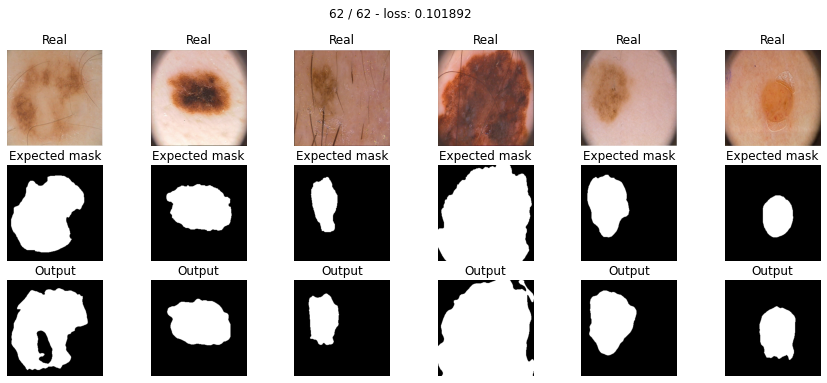

0.784000039100647

In [ ]:
unet_model = UNet().to(device)
torch.cuda.empty_cache()
history_Unet_Dice = train(unet_model, torch.optim.Adam(unet_model.parameters(), lr=1e-03), dice_loss, 62, data_tr, data_val)
score_model(unet_model, iou_pytorch, data_val)

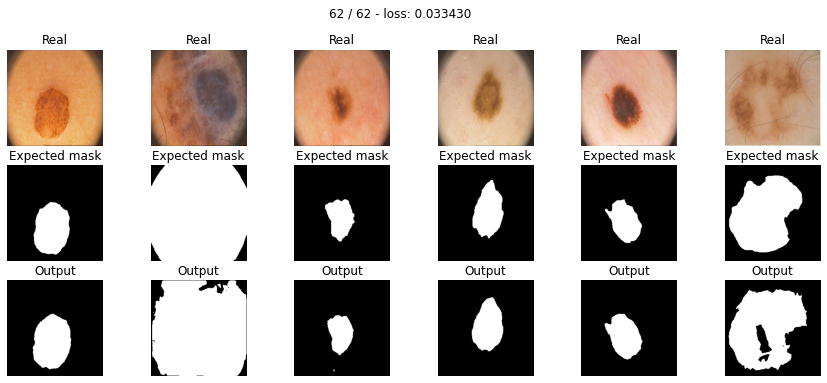

0.7579999923706054

In [ ]:
unet_model = UNet().to(device)
torch.cuda.empty_cache()
history_Unet_focal = train(unet_model, torch.optim.Adam(unet_model.parameters(), lr=1e-03), focal_loss, 62, data_tr, data_val)
score_model(unet_model, iou_pytorch, data_val)

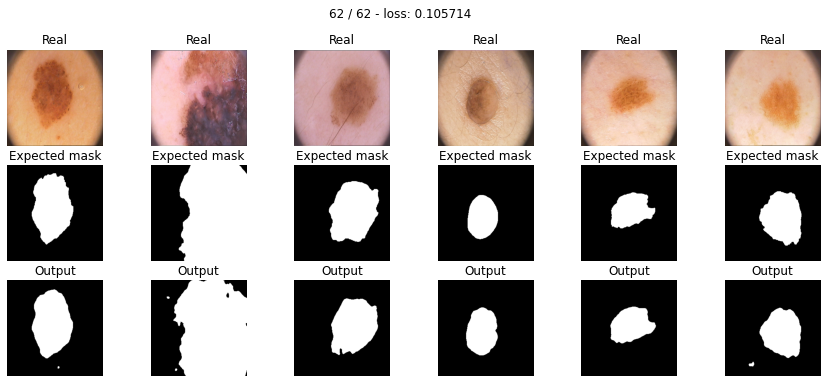

0.8220000624656677

In [ ]:
unet_model = UNet().to(device)
torch.cuda.empty_cache()
history_Unet_tversky = train(unet_model, torch.optim.Adam(unet_model.parameters(), lr=1e-03), tversky_loss, 62, data_tr, data_val)
score_model(unet_model, iou_pytorch, data_val)

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super(UNet2, self).__init__()

        #Downsampling
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
            )
        self.pool0 = nn.MaxPool2d(2)

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        self.pool1 = nn.MaxPool2d(2)

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        self.pool2 = nn.MaxPool2d(2)

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )
        self.pool3 = nn.MaxPool2d(2)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # decoder (upsampling)
        # Тут не уверен совсем, можно ли не менять кол-во каналов (я про upsample0)
        # и будет ли сравнение моделей корректным
        # Можно было бы в bottleneck доделать до 512, но это будет отличаться от Unet вверху
        # Как я понял вариант с ConvTranpose2d должен быть лучше

        self.upsample0 = nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )

        self.upsample1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        
        # 64 -> 128
        self.upsample2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        
        self.upsample3 =  nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec_conv3_ = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
            )
        
        self.dec_conv3 = nn.Conv2d(32, 1, kernel_size=1)


    def forward(self, x):

        e0 = self.enc_conv0(x) # 32

        e1 = self.enc_conv1(self.pool0(e0)) # 64
        e2 = self.enc_conv2(self.pool1(e1)) # 128
        e3 = self.enc_conv3(self.pool2(e2)) # 256

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3)) # 256

        # decoder
        d0 = self.upsample0(b) # 256
        d0 = torch.cat([d0, e3], dim=1) # 512
        d0 = self.dec_conv0(d0) # 256

        d1 = self.upsample1(d0) # 128
        d1 = torch.cat([d1, e2], dim=1) # 256
        d1 = self.dec_conv1(d1) # 128

        d2 = self.upsample2(d1) # 64
        d2 = torch.cat([d2, e1], dim=1) # 128
        d2 = self.dec_conv2(d2) # 64

        d3 = self.upsample3(d2) # 32
        d3 = torch.cat([d3, e0], dim=1) # 64
        d3 = self.dec_conv3_(d3) # 64 -> 32

        preds = self.dec_conv3(d3) # 32 -> 1

        return preds

In [ ]:
unet2_model = UNet2().to(device)

In [ ]:
mod = unet2_model
summary(mod, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             864
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,216
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
         MaxPool2d-7         [-1, 32, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          18,432
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11         [-1, 64, 128, 128]          36,864
      BatchNorm2d-12         [-1, 64, 128, 128]             128
             ReLU-13         [-1, 64, 128, 128]               0
        MaxPool2d-14           [-1, 64,

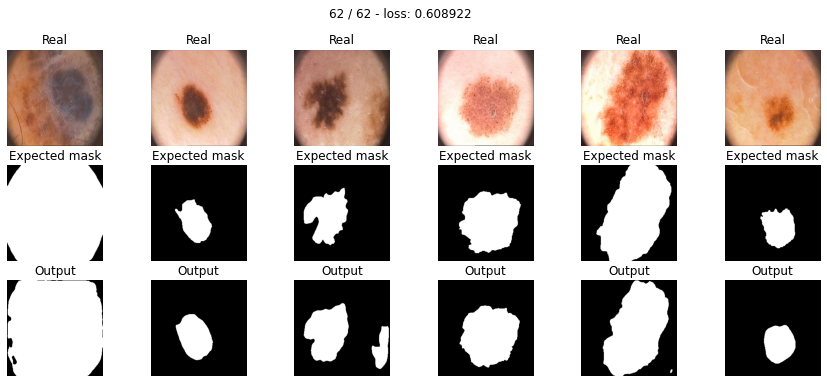

0.6780000448226928

In [ ]:
torch.cuda.empty_cache()
history_unet2_BCE = train(unet2_model, optim.Adam(unet2_model.parameters(), lr=1e-03), bce_loss, 62, data_tr, data_val)
score_model(unet2_model, iou_pytorch, data_val)

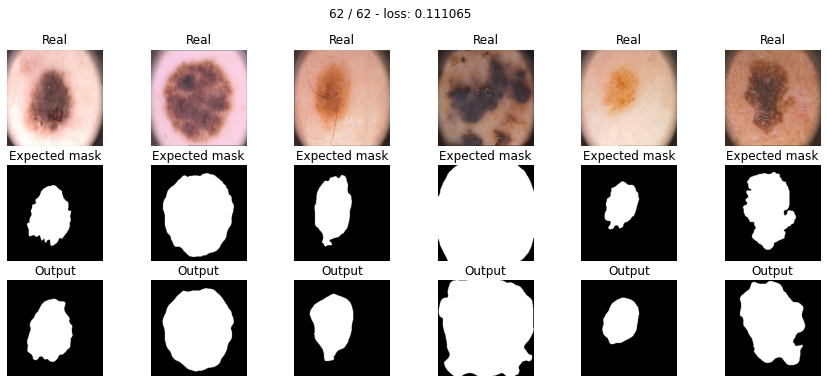

0.6960000276565552

In [ ]:
unet2_model = UNet2().to(device)
torch.cuda.empty_cache()
history_Unet2_Dice = train(unet2_model, optim.Adam(unet2_model.parameters(), lr=1e-03), dice_loss, 62, data_tr, data_val)
score_model(unet2_model, iou_pytorch, data_val)

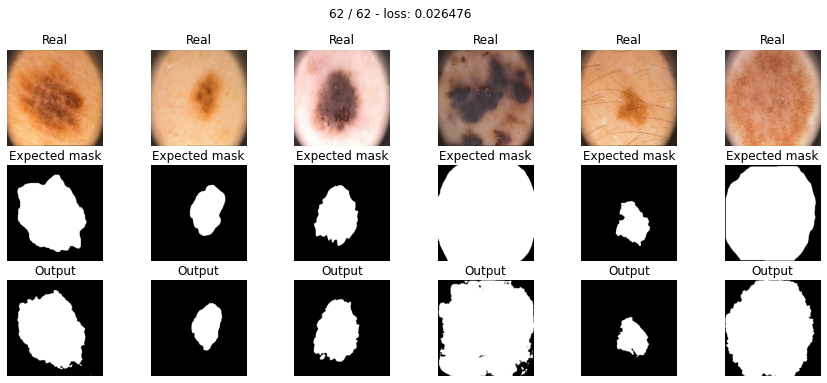

0.6900000095367431

In [ ]:
unet2_model = UNet2().to(device)
torch.cuda.empty_cache()
history_Unet2_focal = train(unet2_model, optim.Adam(unet2_model.parameters(), lr=1e-03), focal_loss, 62, data_tr, data_val)
score_model(unet2_model, iou_pytorch, data_val)

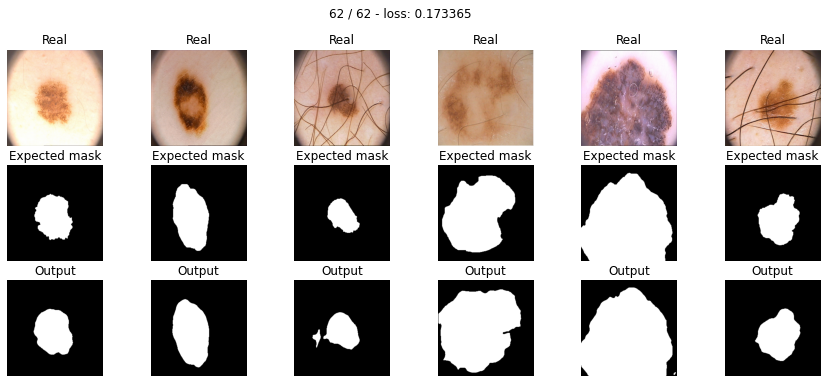

0.7440000534057617

In [ ]:
unet2_model = UNet2().to(device)
torch.cuda.empty_cache()
history_Unet2_tversky = train(unet2_model, optim.Adam(unet2_model.parameters(), lr=1e-03), tversky_loss, 62, data_tr, data_val)
score_model(unet2_model, iou_pytorch, data_val)

### Unet2 с ConvTranspose2d с 512 картами в bottleneck

In [ ]:
class UNet2_512_in_bottl(nn.Module):
    def __init__(self):
        super(UNet2_512_in_bottl, self).__init__()

        #Downsampling
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
            )
        self.pool0 = nn.MaxPool2d(2)

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        self.pool1 = nn.MaxPool2d(2)

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        self.pool2 = nn.MaxPool2d(2)

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )
        self.pool3 = nn.MaxPool2d(2)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )

        self.upsample1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        
        # 64 -> 128
        self.upsample2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        
        self.upsample3 =  nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec_conv3_ = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
            )
        
        self.dec_conv3 = nn.Conv2d(32, 1, kernel_size=1)


    def forward(self, x):

        e0 = self.enc_conv0(x) # 32

        e1 = self.enc_conv1(self.pool0(e0)) # 64
        e2 = self.enc_conv2(self.pool1(e1)) # 128
        e3 = self.enc_conv3(self.pool2(e2)) # 256

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3)) # 512

        # decoder
        d0 = self.upsample0(b) # 256
        d0 = torch.cat([d0, e3], dim=1) # 512
        d0 = self.dec_conv0(d0) # 256

        d1 = self.upsample1(d0) # 128
        d1 = torch.cat([d1, e2], dim=1) # 256
        d1 = self.dec_conv1(d1) # 128

        d2 = self.upsample2(d1) # 64
        d2 = torch.cat([d2, e1], dim=1) # 128
        d2 = self.dec_conv2(d2) # 64

        d3 = self.upsample3(d2) # 32
        d3 = torch.cat([d3, e0], dim=1) # 64
        d3 = self.dec_conv3_(d3) # 64 -> 32

        preds = self.dec_conv3(d3) # 32 -> 1

        return preds

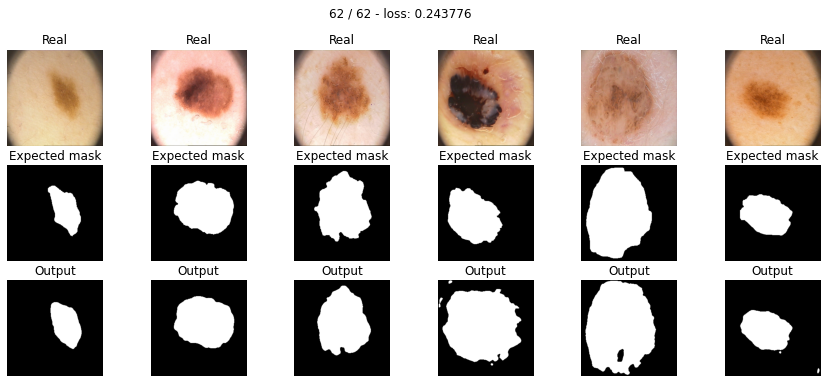

0.7300000309944152

In [ ]:
unet2_model = UNet2_512_in_bottl().to(device)
torch.cuda.empty_cache()
history_Unet2_512_tversky = train(unet2_model, optim.Adam(unet2_model.parameters(), lr=1e-03), tversky_loss, 62, data_tr, data_val)
score_model(unet2_model, iou_pytorch, data_val)

Best acc:  0.7400000691413879


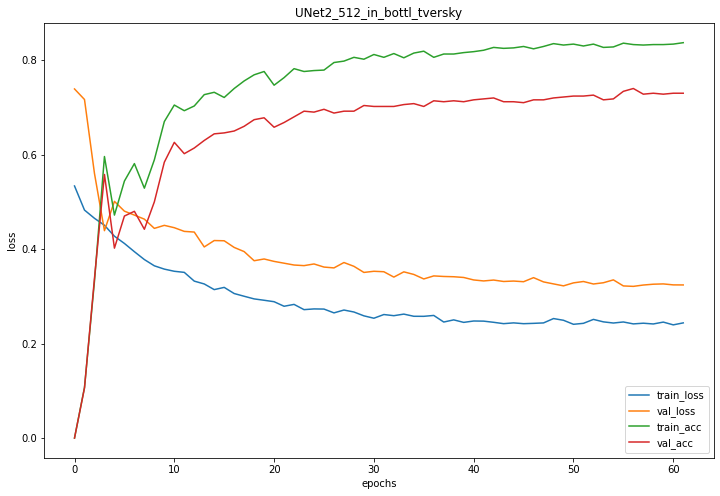

In [ ]:
# Чтобы отрисовать графики нужно запустить функцию plot_results -
# она находится чуть ниже. Если бы я знал как делать ссылки на 
# ячейки или не был кривым инвалидом и дал определение функции в начале ноутбука.
# простите :(
plot_results('UNet2_512_in_bottl_tversky')

### Конец Unet2 с 512 картами в bottleneck
(можно развернуть ячейку выше, чтобы посмотреть разовый эксперимент)

Сделайте вывод какая из моделей лучше:



   '

Допустим моя модель корректна для сравнения с предыдущей (кажется очень вряд ли).

Добавление 512 каналв в bottleneck не дало видимых улучшений. Можно было играться с планировщиками lr, но пока так.

**В целом в моих реализация модель с ConvTranspose2d оказалось хуже, чем с upsample.**

Буду искать в чем отличие.


# Dilated convolutions [1 балл]



Еще один из вариантов делать upsampling и downsampling - использовать для этого *dilated convolutions*:


* Yu, Fisher, and Vladlen Koltun. "[Multi-scale context aggregation by dilated convolutions.](https://arxiv.org/pdf/1511.07122.pdf)" arXiv preprint arXiv:1511.07122 (2015).

попробуйте написать сеть DilatedUNet, которая использует в одной из предыдущих моделей dilated свертки.

In [ ]:
class DilatedUnet(nn.Module):
    def __init__(self):
        super(DilatedUnet, self).__init__()

        #Downsampling
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
            )
        self.pool0 = nn.MaxPool2d(2)

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        self.pool1 =  nn.MaxPool2d(2)

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        self.pool2 = nn.MaxPool2d(2)

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )
        self.pool3 = nn.MaxPool2d(2)

        '''
        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        '''

        '''
        Как я почитал по комментам на степике dilated свертки
        делают в bottleneck
        '''
        self.bottleneck_list = nn.ModuleList()
                    
        for i in range(6):
            self.bottleneck_list.append(
                nn.Sequential
                (
                    nn.Conv2d(256, 256, kernel_size=3, dilation=2**i, padding=2**i, bias=False),
                    nn.BatchNorm2d(256),
                    nn.ReLU()
                )
                                    )

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(32)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )

        self.upsample1 = nn.Upsample(64)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(384, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        
        # 64 -> 128
        self.upsample2 = nn.Upsample(128)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(192, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        
        self.upsample3 =  nn.Upsample(256)
        self.dec_conv3_ = nn.Sequential(
            nn.Conv2d(96, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
            )
        
        self.dec_conv3 = nn.Conv2d(32, 1, kernel_size=1)


    def forward(self, x):

        e0 = self.enc_conv0(x) # 32

        e1 = self.enc_conv1(self.pool0(e0)) # 64
        e2 = self.enc_conv2(self.pool1(e1)) # 128
        e3 = self.enc_conv3(self.pool2(e2)) # 256

        # bottleneck
        # b = self.bottleneck_conv(self.pool3(e3)) # 256

        dilated_layers = []
        for i, bottleneck in enumerate(self.bottleneck_list):
            b = bottleneck(e3)
            dilated_layers.append(b.unsqueeze(-1))

        b = torch.cat(dilated_layers, dim=-1)
        b = torch.sum(b, dim=-1)
        # print(b.shape)

        # decoder
        d0 = self.upsample0(b)
        d0 = torch.cat([d0, e3], dim=1) # 512
        d0 = self.dec_conv0(d0) # 256

        d1 = self.upsample1(d0) 
        d1 = torch.cat([d1, e2], dim=1) # 384
        d1 = self.dec_conv1(d1) # 128

        d2 = self.upsample2(d1)
        d2 = torch.cat([d2, e1], dim=1) # 192
        d2 = self.dec_conv2(d2) # 64

        d3 = self.upsample3(d2)
        d3 = torch.cat([d3, e0], dim=1) # 96
        d3 = self.dec_conv3_(d3) # 96 -> 32

        preds = self.dec_conv3(d3) # 32 -> 1

        return preds

In [ ]:
# mod = DilatedUNet().to(device)
# a = torch.range(1, 589824) # 256*256*3*3
# mod.forward(a.view(-1, 3, 256, 256).to(device))

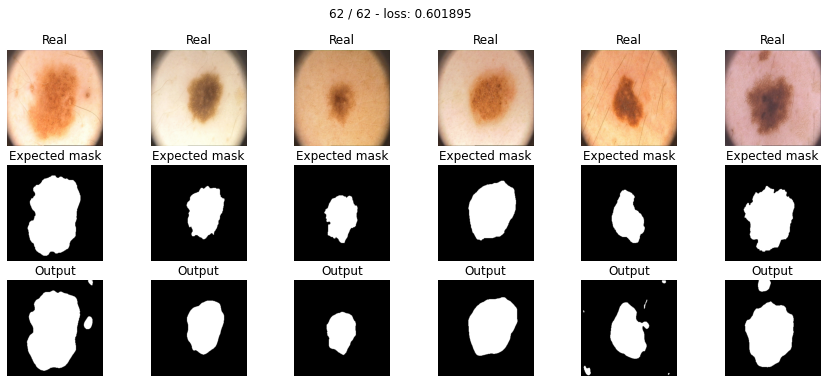

0.7880000233650207

In [ ]:
model = DilatedUnet().to(device)
torch.cuda.empty_cache()
history_DilatedUnet_BCE = train(model, optim.Adam(model.parameters(), lr=1e-03), bce_loss, 62, data_tr, data_val)
score_model(model, iou_pytorch, data_val)

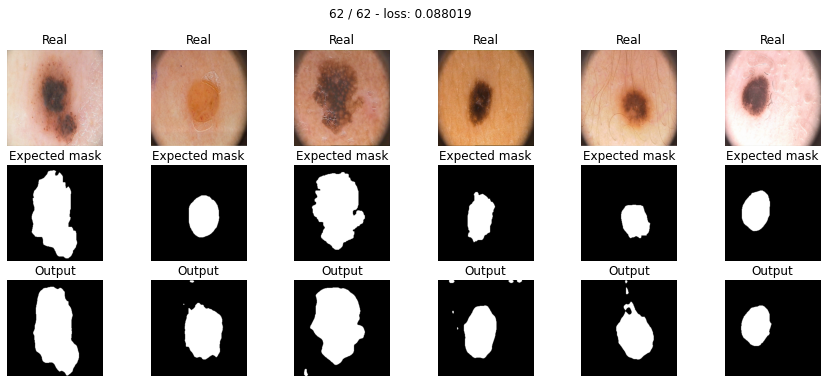

0.7680000305175781

In [ ]:
model = DilatedUnet().to(device)
torch.cuda.empty_cache()
history_DilatedUnet_Dice = train(model, optim.Adam(model.parameters(), lr=1e-03), dice_loss, 62, data_tr, data_val)
score_model(model, iou_pytorch, data_val)

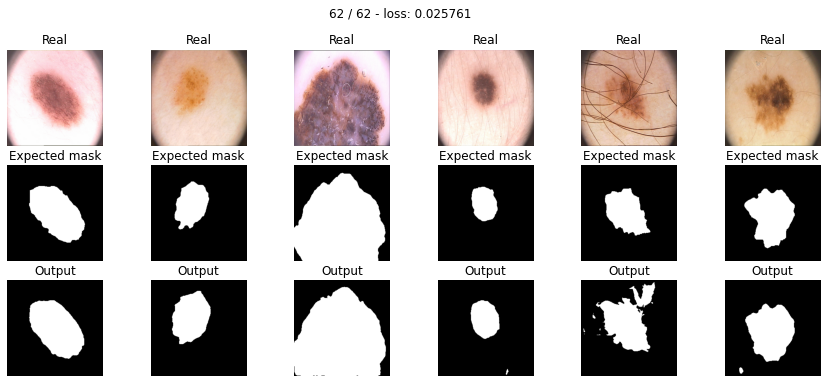

0.7600000500679016

In [ ]:
model = DilatedUnet().to(device)
torch.cuda.empty_cache()
history_DilatedUnet_focal = train(model, optim.Adam(model.parameters(), lr=1e-03), focal_loss, 62, data_tr, data_val)
score_model(model, iou_pytorch, data_val)

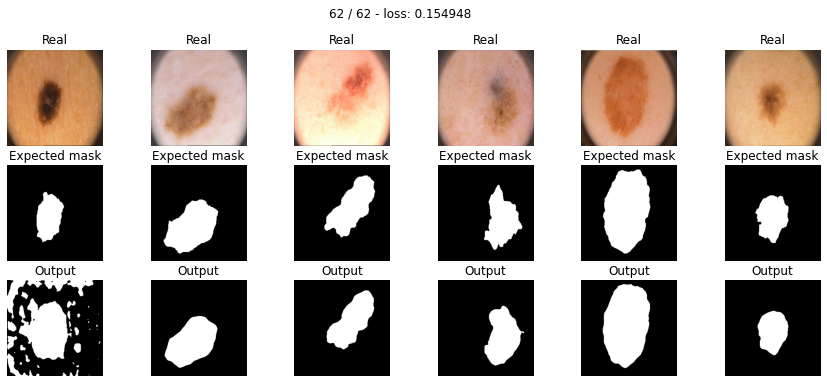

0.778000020980835

In [ ]:
model = DilatedUnet().to(device)
torch.cuda.empty_cache()
history_DilatedUnet_tversky = train(model, optim.Adam(model.parameters(), lr=1e-03), tversky_loss, 62, data_tr, data_val)
score_model(model, iou_pytorch, data_val)

# Отчет (5 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 

Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверябщий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.



Можно было бы варьировать изменения lr во время обучения, но я тестировал все с одинаковым планировщиком. Скорее всего результаты могли бы отличаться.

На текущей версии `SegNet` с парой перезапусков лучший скор был с `bce_loss` (если, конечно, остальные лоссы реализованы примерно правильно) и равен *0.78*.
А с `tversky_loss` дала самый плохой результат.

---

`Unet` дала лучший скор на `tversky_loss`: *0.822*

---

`Unet2` давала лучший скор тоже на `tversky_loss`: *0.748*

---

`DilatedUnet` без ConvTranspose дала лучший скор на `BCE`: *0.804*

---

В целом dice_loss показывает себя хорошо на всех моделях стабильно. 

In [ ]:
def plot_results(model_name_with_loss: str):
    
    assert type(model_name_with_loss) == str, 'Введите строку в \'\''

    # Наверное пополнение словаря делается как-то умнее
    # Ну или defaultdict какой-то чтобы словарь не ломался, если переменная не объявлена

    '''
    Если запустите обучение (вряд ли вам нужно проверять все подряд), 
    то для запуска этой функции нужно закомментить необъявленные переменные.
    Еще раз простите, но править уже не успею
    Хоть для какого-то удобства я старался чтобы все результаты 
    сохранились в ноутбуке видимыми без запуска
    '''
    model_names_with_losses = {
        # 'SegNet_BCE': history_Seg_BCE,
        # 'SegNet_Dice': history_Seg_Dice,
        # 'SegNet_focal': history_Seg_focal,
        # 'SegNet_tversky': history_Seg_tversky,
        # 'Unet_BCE': history_Unet_BCE,
        # 'Unet_Dice': history_Unet_Dice,
        # 'Unet_focal': history_Unet_focal,
        # 'Unet_tversky': history_Unet_tversky,
        # 'Unet2_BCE': history_unet2_BCE,
        # 'Unet2_Dice': history_Unet2_Dice,
        # 'Unet2_focal': history_Unet2_focal,
        # 'Unet2_tversky': history_Unet2_tversky,
        # 'DilatedUnet_BCE': history_DilatedUnet_BCE,
        # 'DilatedUnet_Dice': history_DilatedUnet_Dice,
        # 'DilatedUnet_focal': history_DilatedUnet_focal,
        # 'DilatedUnet_tversky': history_DilatedUnet_tversky,
        # 'UNet2_512_in_bottl_tversky': history_Unet2_512_tversky
    }

    train_loss, train_acc, val_loss, val_acc = zip(*model_names_with_losses.get(model_name_with_loss))

    plt.figure(figsize=(12, 8))
    plt.plot(train_loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.plot(train_acc, label="train_acc")
    plt.plot(val_acc, label="val_acc")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title(model_name_with_loss)
    print('Best acc: ', torch.max(torch.tensor(val_acc)).item())
    plt.show()

Best acc:  0.7800000309944153


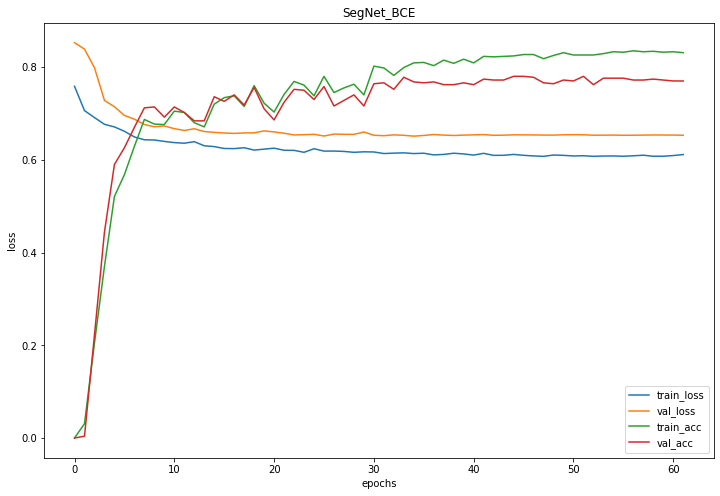

In [ ]:
plot_results('SegNet_BCE')

Best acc:  0.7740000486373901


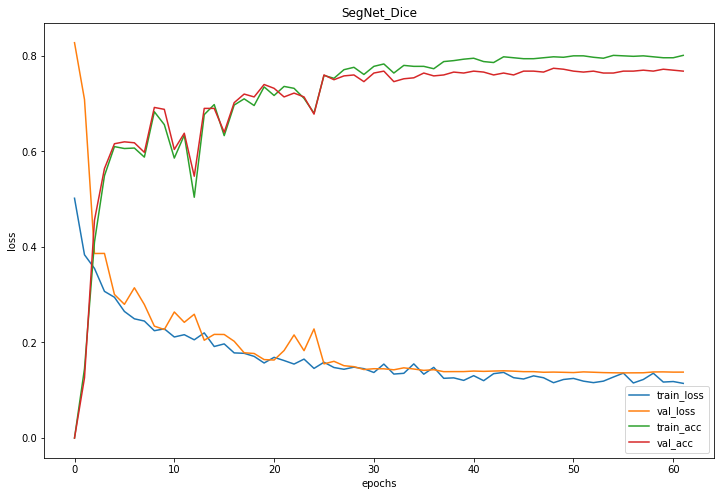

In [ ]:
plot_results('SegNet_Dice')

Best acc:  0.7700000405311584


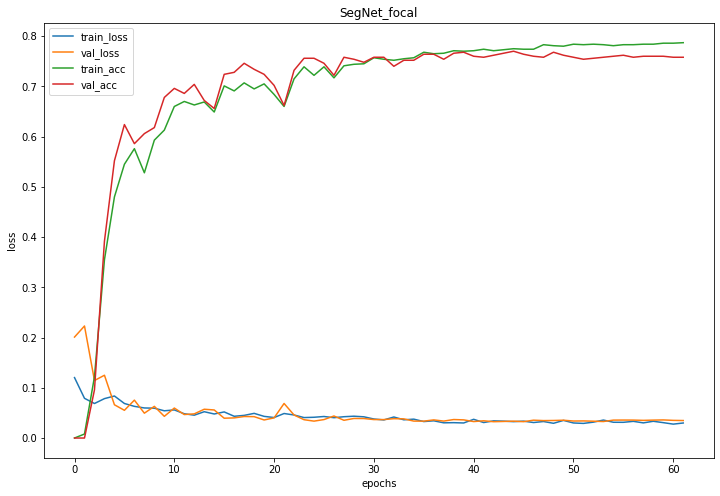

In [ ]:
plot_results('SegNet_focal')

Best acc:  0.5839999914169312


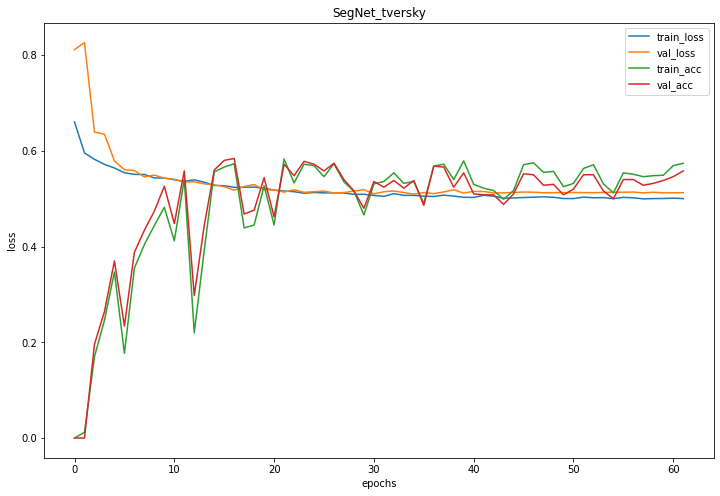

In [ ]:
plot_results('SegNet_tversky')

Best acc:  0.7020000219345093


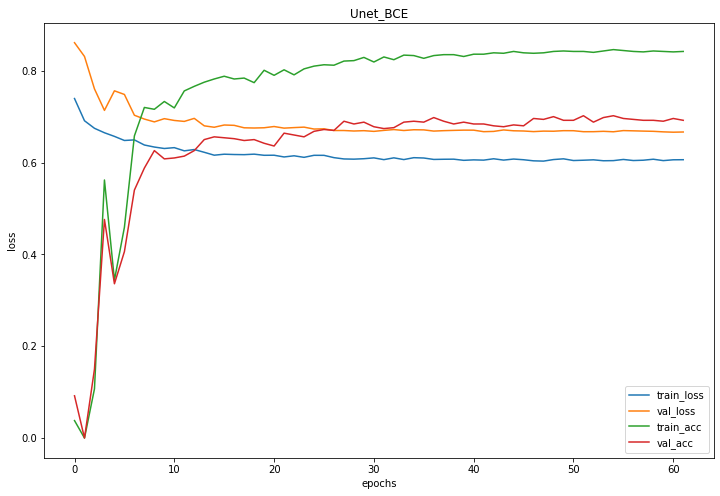

In [ ]:
plot_results('Unet_BCE')

Best acc:  0.8020000457763672


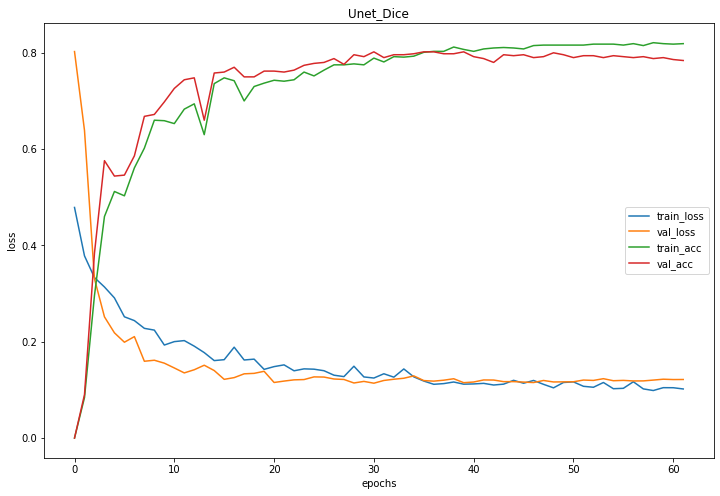

In [ ]:
plot_results('Unet_Dice')

Best acc:  0.7720000147819519


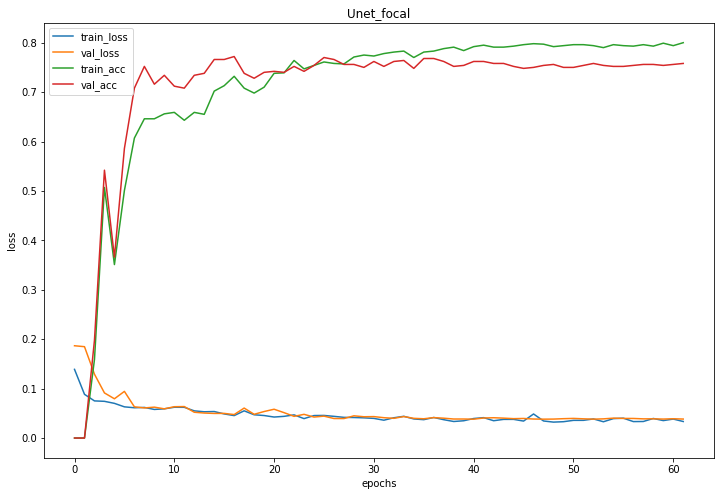

In [ ]:
plot_results('Unet_focal')


Best acc:  0.8220000267028809


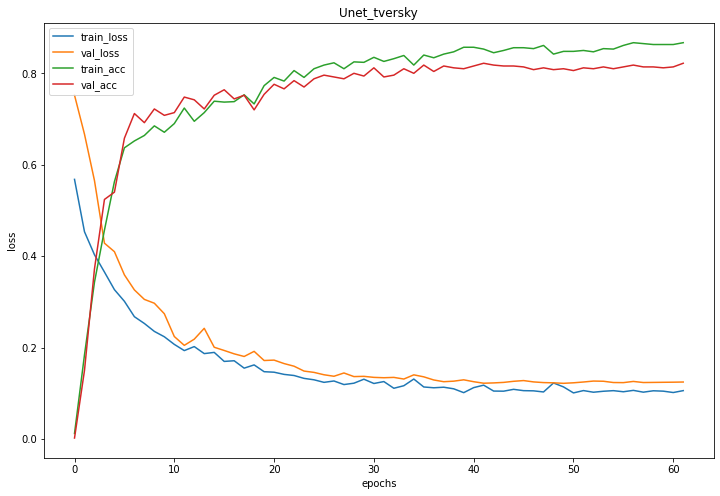

In [ ]:
plot_results('Unet_tversky')

Best acc:  0.6800000071525574


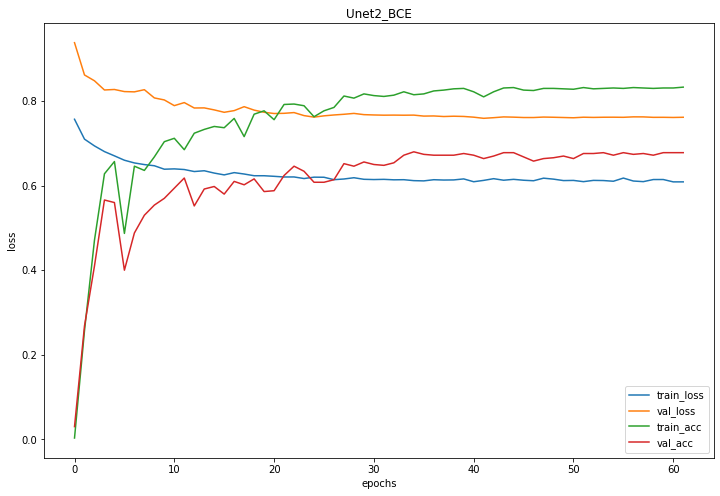

In [ ]:
plot_results('Unet2_BCE')

Best acc:  0.7039999961853027


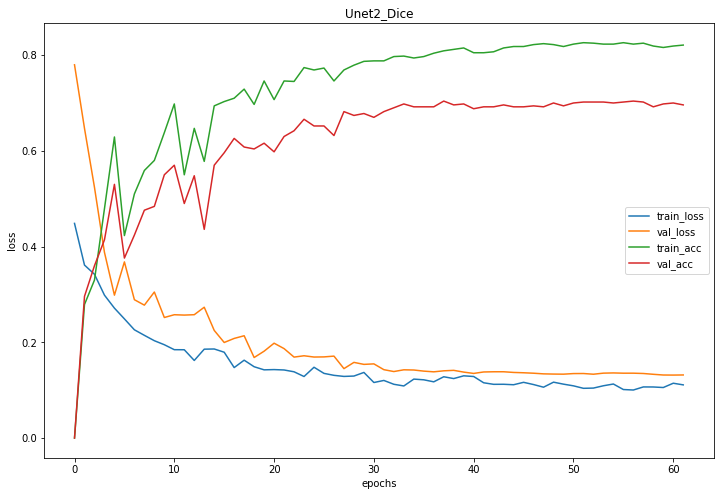

In [ ]:
plot_results('Unet2_Dice')

Best acc:  0.7020000219345093


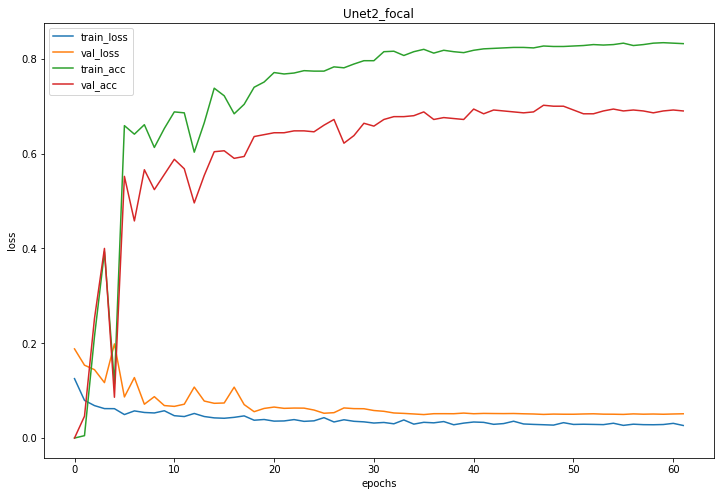

In [ ]:
plot_results('Unet2_focal')

Best acc:  0.7480000257492065


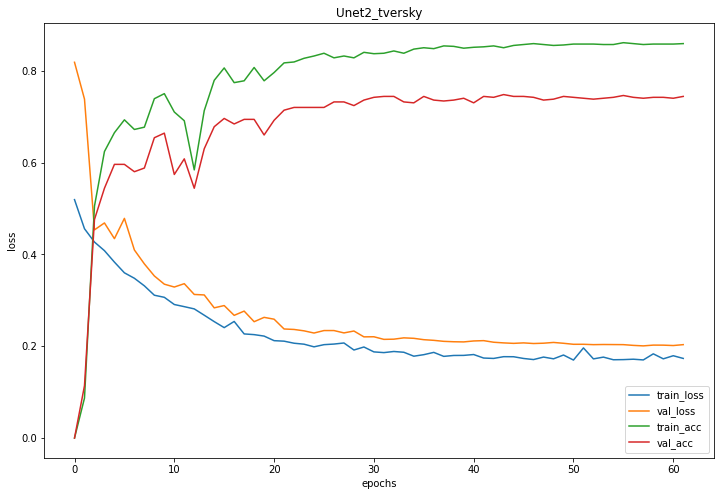

In [ ]:
plot_results('Unet2_tversky')

Best acc:  0.8040000796318054


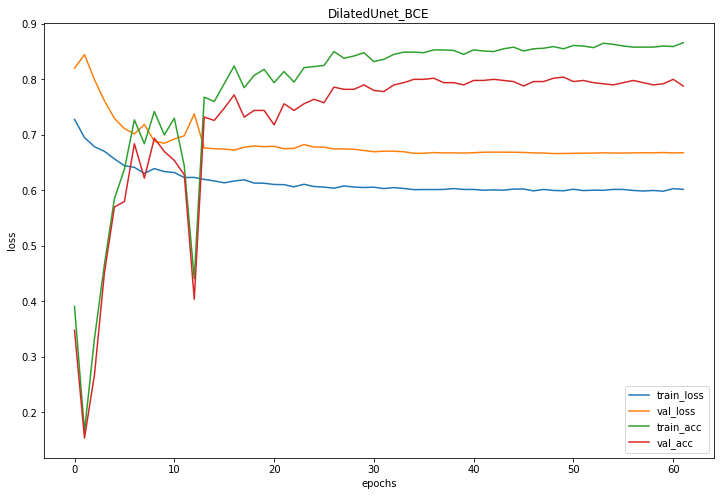

In [ ]:
plot_results('DilatedUnet_BCE')

Best acc:  0.768000066280365


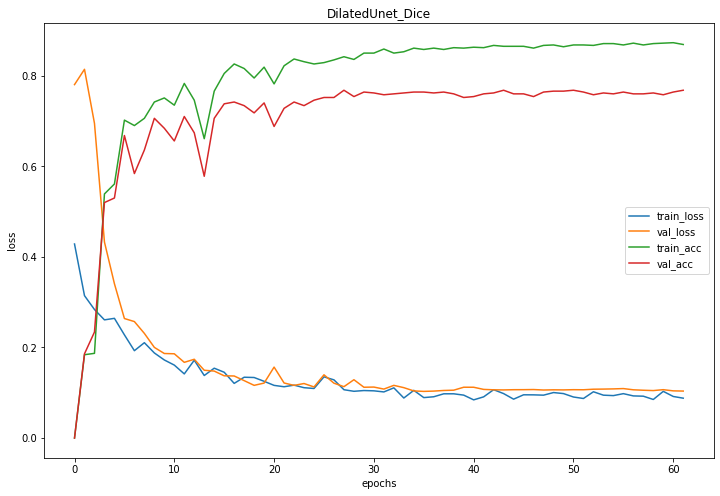

In [ ]:
plot_results('DilatedUnet_Dice')

Best acc:  0.7660000324249268


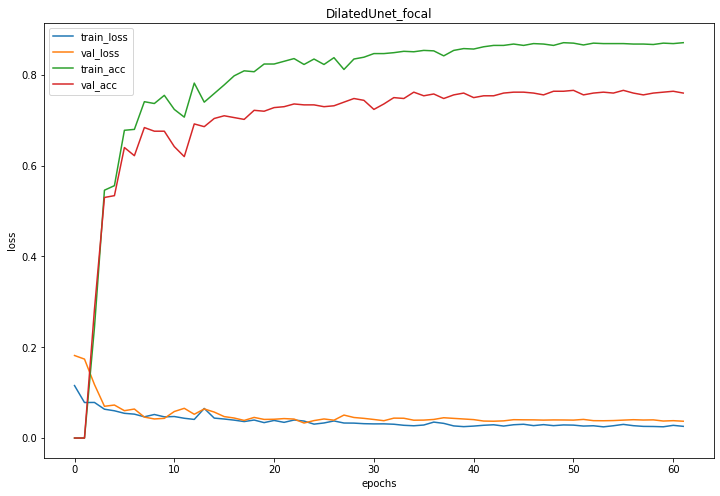

In [ ]:
plot_results('DilatedUnet_focal')

Best acc:  0.784000039100647


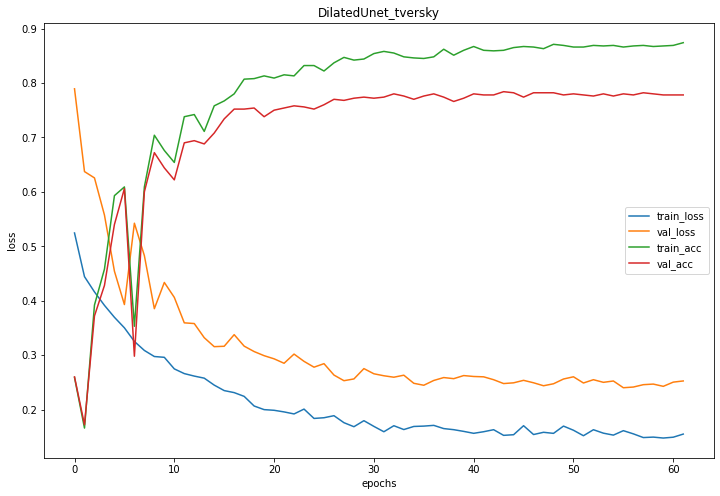

In [ ]:
plot_results('DilatedUnet_tversky')